## Image Captioning Capstone project

* Author : S S B Phani Pradeep Miriyala

### 1. Pre processing

#### 1.1 Load libraries

In [1]:
import numpy as np
import pandas as pd

%pylab inline
import glob
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import string
from PIL import Image
from skimage import io

from sklearn.model_selection import train_test_split
import tensorflow as tf

from nltk.translate.bleu_score import sentence_bleu

from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


#### 1.2 Define input, intermediate and output paths

In [2]:
img_folder = os.path.join('/','kaggle','input','flickr8k','Images')
cap_file = os.path.join('/','kaggle','input','flickr8k','captions.txt')
img_files = glob.glob(os.path.join(img_folder,'*.jpg'),recursive=True)
work_folder = os.path.join('/','kaggle','working')
print(f'Total images in archive : {len(img_files)}')

Total images in archive : 8091


#### 1.3 Load captions from captions text file.
Captions text file will contain 5 captions for each image.

In [3]:
# Load the captions in to a data frame.
cap_df = pd.read_csv(cap_file)
print(f'Total Captions in file : {cap_df.shape[0]}')
cap_df.head()

Total Captions in file : 40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


Store image ids and captions in a dictionary. Since for each image, there are multiple captions, we will concatenate captions together to form one big string.

Captions are differentiated by tags "< start >" and "< end >"

In [4]:
# Group all captions together having the same image ID.
# Add "start" and "end" tokens to each caption.
start_token = '<start>'
end_token = '<end>'
oov_token = '<unk>'
image_path_to_caption = defaultdict(list)
for idx, row in cap_df.iterrows():
    caption = f'{start_token} {row.caption} {end_token}'
    im_path = os.path.join(img_folder,row['image'])
    image_path_to_caption[im_path].append(caption)
print(f"Total captions present in the dataset: {len(cap_df['caption'])}")
print(f"Total images present in the dataset: {len(img_files)}")

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


#### 1.4 Visualize caption and image

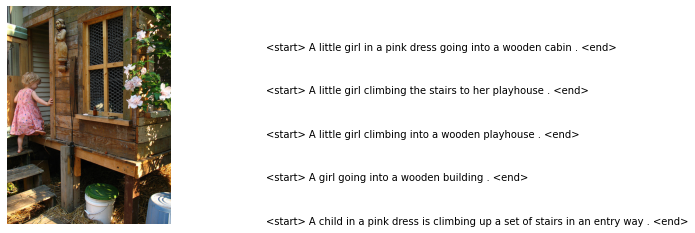

In [5]:
image_paths = list(image_path_to_caption.keys())
all_captions = []
img_name_vector = []
for image_path in image_paths:
    caption_list = image_path_to_caption[image_path]
    all_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

f, axes = plt.subplots(1, 2)
plt.axis('off')
f.set_figwidth(10)
axes[0].imshow(io.imread(img_name_vector[0]))
axes[0].axis('off')
axes[1].set_ylim(0,5)
for i in range(0,5):
    axes[1].text(0,i,all_captions[i])

#### 1.5 Vecotrize words

In [6]:
# Select Top 5000 tokens
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_k,
                                                  oov_token = oov_token,
                                                  filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(all_captions)

In [7]:
pad_token = '<pad>'
tokenizer.word_index[pad_token] = 0
tokenizer.index_word[0] = pad_token

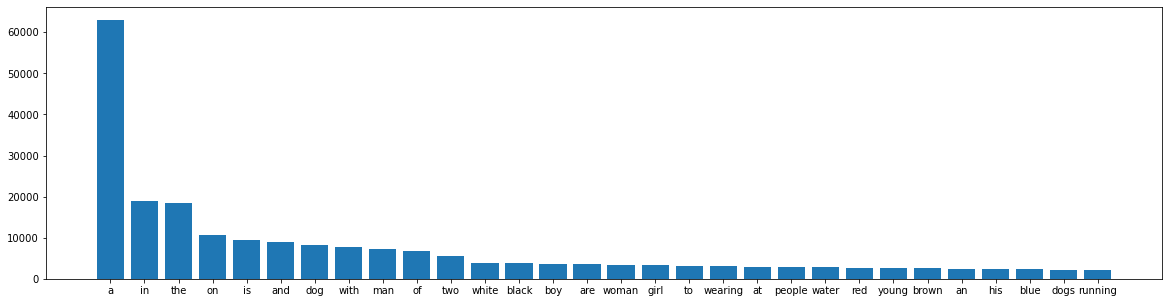

In [8]:
# Get top 30 words by frequency.
vals = sorted(tokenizer.word_counts.items(),key=lambda x:x[1],reverse=True)
words = [x[0] for x in vals[:32] if x[0] not in [start_token,end_token]]
cnts = [x[1] for x in vals[:32] if x[0] not in [start_token,end_token]]
plt.figure(figsize=(20,5))
f = plt.bar(words,cnts)

In [9]:
# Create the tokenized vectors
txt_seqs = tokenizer.texts_to_sequences(all_captions)

#### 1.6 Make all caption vectors equal sized

In [10]:
def calc_max_length(tensor):
    '''Get maximum length of any caption in the data set'''
    return max(len(t) for t in tensor)
# Pad each vector to the# max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(txt_seqs, padding='post')
max_length = calc_max_length(txt_seqs)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


### 2. Model building
#### 2.1 Prepare training and test data sets.

In [11]:
TRAIN_SIZE = 0.8
RAND_STATE = 42
tf.random.set_seed(RAND_STATE)
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, train_size = TRAIN_SIZE, random_state = RAND_STATE)

In [12]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32364, 32364, 8091, 8091)

#### 2.2 Image processing

In [13]:
def load_image(image_path):
    '''Load image for feature extraction. Below operations are performed:
    1. Rescaling to 299x299 pixels
    2. Normalization of image to range of (-1,1)
    '''
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    # preprocess_input will normalize input to range of -1 to 1
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

Use InceptionV3 model as base model. We will use features extracted by inception model.

In [14]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In image data set there will be repetitions. So, we will select only unique images.

In [15]:
img_set = sorted(set(img_name_vector))
np_cache = os.path.join(work_folder,'npy_cache')
if not os.path.isdir(np_cache):
    os.mkdir(np_cache) 

IMG_BATCH_SIZE = 64
img_dataset = tf.data.Dataset.from_tensor_slices(img_set)
img_dataset = img_dataset.map(load_image, num_parallel_calls = tf.data.AUTOTUNE).batch(IMG_BATCH_SIZE)
for img, path in tqdm(img_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    
    for bf, p in zip(batch_features, path):        
        path_of_feature = p.numpy().decode("utf-8")
        op_path = os.path.join(np_cache,os.path.basename(path_of_feature)+".npy")
        np.save(op_path, bf.numpy())

100%|██████████| 127/127 [01:00<00:00,  2.08it/s]


In [16]:
sample_img_batch, sample_cap_batch = next(iter(img_dataset))
print(sample_img_batch.shape)
print(sample_cap_batch.shape)

(64, 299, 299, 3)
(64,)


#### 2.3 Define parameters for RNN (Encoder-Decoder) model

In [17]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 784
units = 512

vocab_size = top_k + 1
train_num_steps = len(img_name_train) // BATCH_SIZE
test_num_steps = len(img_name_val) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

#### 2.4 Prepare RNN training and test data sets.

In [18]:
def load_img_features(img_name, cap):
    '''Function to load previously stored npy cache files from np cache folder.
    Each image will have one npy file.
    '''
    op_path = os.path.join(np_cache,os.path.basename(img_name.decode('utf-8'))+".npy")
    img_tensor = np.load(op_path)
    return img_tensor, cap

Prepare training data set

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(load_img_features, [item1, item2], 
                                                                         [tf.float32, tf.int32]))
# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Prepare test data set

In [20]:
test_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(load_img_features, [item1, item2], [tf.float32, tf.int32]))
# Shuffle and batch
test_dataset = test_dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=False).batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

#### 2.5 Define RNN encoder class

In [21]:
class Encoder(tf.keras.Model):
    '''Derived from Model super class'''
    def __init__(self, embedding_dim):
        '''Constructor takes embedding dimensions and prepares encoder layer.'''
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def call(self, features, training=False):
        '''Call to Encoder layer'''
        features = self.dense(features)
        features = tf.nn.relu(features)
        return features

Define encoder object.

In [22]:
encoder = Encoder(embedding_dim)

#### 2.6 Define Bahdanau Attention Model

In [23]:
class BahdanauAttention(tf.keras.Model):
    '''Derived from Model super class'''
    def __init__(self, units):
        '''Constructor'''
        super(BahdanauAttention, self).__init__()
        self.units = units
        self.W1 = tf.keras.layers.Dense(self.units)
        self.W2 = tf.keras.layers.Dense(self.units)
        self.V = tf.keras.layers.Dense(1)        

    def call(self, features, hidden):
        '''Call to attention layer'''
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))
        
        score = self.V(attention_hidden_layer)
        
        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

#### 2.7 Define RNN Decoder layer

In [24]:
class Decoder(tf.keras.Model):
    '''Derived from Model super class'''
    def __init__(self, embedding_dim, units, vocab_size):
        '''Constructor'''
        super(Decoder, self).__init__()
        self.units = units
        # Add attention layer object.
        self.attention = BahdanauAttention(self.units)
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences = True,
                                       return_state = True,
                                       recurrent_initializer = 'glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)
        self.d2 = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x, features, hidden):
        '''Call to decoder layer.'''
        context_vector, attention_weights = self.attention(features, hidden)
        
        embed = self.embed(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(embed)

        x = self.d1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.d2(x)
        
        return x, state, attention_weights

    def reset_state(self, batch_size):
        '''Reset decoder state.'''
        return tf.zeros((batch_size, self.units))

Define decoder object

In [25]:
decoder = Decoder(embedding_dim, units, vocab_size)

### 3. Build model

In [26]:
LR = 2e-4
# Using Adam optimizer and Sparse Categorical Cross entropy for loss.
optimizer = tf.keras.optimizers.Adam(learning_rate = LR)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction='none')

In [27]:
checkpoint_path = os.path.join(work_folder,'checkpoint')
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

#### 3.1 Define Loss function

In [28]:
def loss_function(real, pred):
    '''Define function to calculate loss value based on real and prediction values.'''
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    return tf.reduce_mean(loss)

#### 3.2 Define Train step function

In [29]:
@tf.function
def train_step(img_tensor, target):
    '''Step function for training.'''
    loss = 0
    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size = target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index[start_token]] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss, total_loss

#### 3.3 Define test step and loss function

In [30]:
@tf.function
def test_step(img_tensor, target):
    '''Step function for test'''
    loss = 0

    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index[start_token]] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)
        predicted_id = tf.argmax(predictions[0])
        dec_input = tf.expand_dims([predicted_id] * target.shape[0] , 1)

    avg_loss = (loss / int(target.shape[1]))

    return loss, avg_loss

In [31]:
def test_loss_cal(dataset):
    '''Function to calculate total test loss.'''
    total_loss = 0

    for (batch,(img_tensor,target)) in enumerate(dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    
    return total_loss/int(target.shape[1])

### 4 Train RNN Encoder-Decoder model

In [32]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15
best_test_loss = 100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0
        
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.441, & test loss is 6.277
Time taken for 1 epoch 184.67662024497986 sec

Test loss has been reduced from 100.000 to 6.277


 13%|█▎        | 2/15 [04:57<30:52, 142.48s/it]

For epoch: 2, the train loss is 1.127, & test loss is 6.474
Time taken for 1 epoch 112.75921607017517 sec



 20%|██        | 3/15 [06:50<25:48, 129.03s/it]

For epoch: 3, the train loss is 1.017, & test loss is 6.326
Time taken for 1 epoch 113.01145482063293 sec



 27%|██▋       | 4/15 [08:42<22:23, 122.10s/it]

For epoch: 4, the train loss is 0.949, & test loss is 6.442
Time taken for 1 epoch 111.49014663696289 sec



 33%|███▎      | 5/15 [10:33<19:43, 118.34s/it]

For epoch: 5, the train loss is 0.895, & test loss is 6.471
Time taken for 1 epoch 111.67767977714539 sec



 40%|████      | 6/15 [12:25<17:23, 115.92s/it]

For epoch: 6, the train loss is 0.849, & test loss is 6.534
Time taken for 1 epoch 111.20629644393921 sec



 47%|████▋     | 7/15 [14:17<15:18, 114.83s/it]

For epoch: 7, the train loss is 0.809, & test loss is 6.475
Time taken for 1 epoch 112.5925657749176 sec



 53%|█████▎    | 8/15 [16:09<13:18, 114.03s/it]

For epoch: 8, the train loss is 0.774, & test loss is 6.655
Time taken for 1 epoch 112.3000659942627 sec



 60%|██████    | 9/15 [18:02<11:21, 113.53s/it]

For epoch: 9, the train loss is 0.740, & test loss is 6.666
Time taken for 1 epoch 112.43498516082764 sec



 67%|██████▋   | 10/15 [19:54<09:24, 112.99s/it]

For epoch: 10, the train loss is 0.710, & test loss is 6.734
Time taken for 1 epoch 111.77477884292603 sec



 73%|███████▎  | 11/15 [21:46<07:30, 112.66s/it]

For epoch: 11, the train loss is 0.682, & test loss is 6.661
Time taken for 1 epoch 111.91122245788574 sec



 80%|████████  | 12/15 [23:40<05:39, 113.08s/it]

For epoch: 12, the train loss is 0.657, & test loss is 6.672
Time taken for 1 epoch 114.05171942710876 sec



 87%|████████▋ | 13/15 [25:32<03:45, 112.94s/it]

For epoch: 13, the train loss is 0.636, & test loss is 6.980
Time taken for 1 epoch 112.62083530426025 sec



 93%|█████████▎| 14/15 [27:23<01:52, 112.37s/it]

For epoch: 14, the train loss is 0.605, & test loss is 6.949
Time taken for 1 epoch 111.04408884048462 sec



100%|██████████| 15/15 [29:15<00:00, 117.05s/it]

For epoch: 15, the train loss is 0.587, & test loss is 7.131
Time taken for 1 epoch 111.96280026435852 sec



#### 4.1 Training and test loss visualization

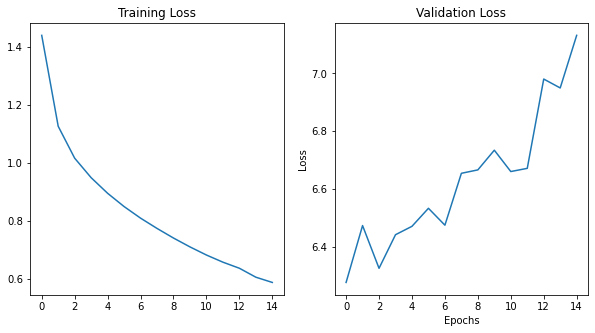

In [33]:
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.plot(loss_plot)
plt.title('Training Loss')
plt.subplot(1,2,2)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show()

### 5. Model evaluation
#### 5.1 Define function for model evaluation

In [34]:
def evaluate(image):
    '''Evaluates the model prediction by comparing real and prediction'''
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index[start_token]], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        if tokenizer.index_word[predicted_id] == oov_token:
            # Ignore out of vocabulary predictions.
            continue
            
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == end_token:
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

#### 5.2 Define function for plotting attention detail from prediction

In [35]:
def plot_attention(image, result, attention_plot):
    '''Plot attention detail from each word in predicted sequence'''
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        if l+1>(len_result//2)*(len_result//2): continue
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

#### 5.3 Evaluation with random image from test set

In [36]:
def show_prediction(random_id,captions_set,img_names,tokenizer):
    '''Display prediction of image.'''
    image = img_name_val[random_id]
    real_caption = ' '.join([tokenizer.index_word[i] for i in captions_set[random_id] if i not in [0]])
    result, attention_plot = evaluate(image)
    
    print(f'Image {random_id} : {image}')
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', ' '.join(result))
    pred_caption = ' '.join(result)
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=(0.2, 0.2, 0.45, 0.15))
    print(f"BELU score: {score*100}")
    plot_attention(image, result, attention_plot)

Image 7634 : /kaggle/input/flickr8k/Images/2257798999_d9d1b9a45a.jpg
Real Caption: <start> as the brown dog looks the other way a large black and white dog plays with a smaller black dog <end>
Prediction Caption: two dogs playing in the grass <end>
BELU score: 9.131778284711373


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


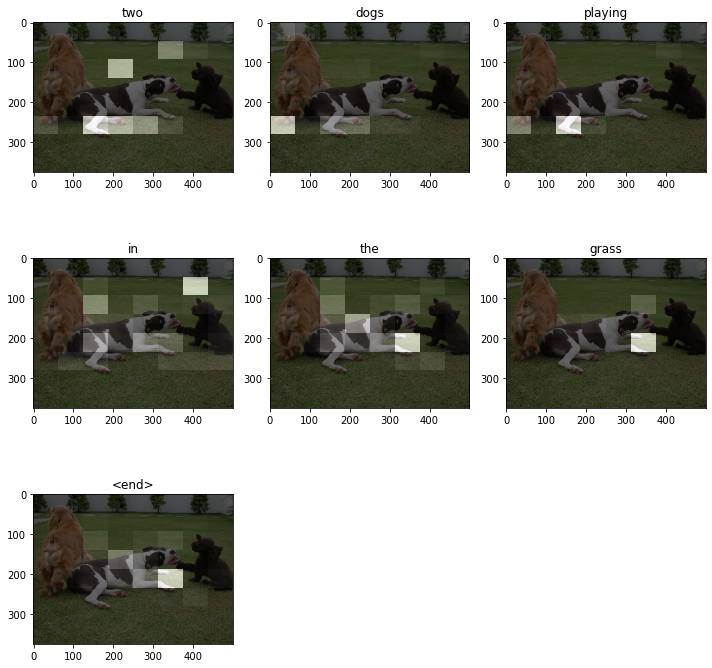

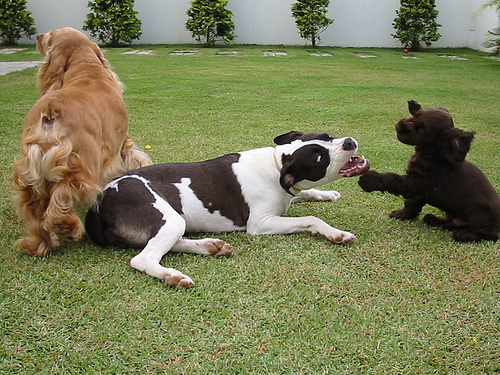

In [37]:
rid = np.random.randint(0, len(img_name_val))
show_prediction(rid,cap_val,img_name_val,tokenizer)
Image.open(img_name_val[rid])